In [110]:
print("Jupyter is ready for CE40248")

Jupyter is ready for CE40248


Input -> Calculate forces and integrate equations of motion -> perform P, control T if necessary -> t = t + deltT -> Calculate and update the molecule position (-> t<tmax back to the calcualte forces tab) -> Output: key output is a trajectory file with positions at a given time, here the thermodynamics and transport properties are determined....

Sigma is the diameter of atom and epsilon is the energy of the particle

In order to control reaction in terms of energy, need to completely isolate the system. This is not physically 100% possible. Come with a theoretical limit. 

If try to determine a parameter, do not use the equilibration zone

Limitations - not considering rotational or vibrational energy

CE40248 Coursework: Molecular Dynamics
Author: Alex Pooley
Date edited: 27/10/2025
Description: Code takes a series of parameters within a system and using the Lennard-Jones potential, calculates force and velocity to create a file of positions in space, for each molecule for each time step.

In [111]:
# Import packages needed
import numpy as np
import matplotlib.pyplot as plt

INSERT LJ EQUATIONS

In [112]:
# Lennard Jones function(s) - tail corrections add, bond angles to zero at equilibrium?

def U_LJ(r, sigma, epsilon): 
    # Function to calculate potential energy, using LJ potential.
    U = 4 * epsilon * ((sigma/r)**12 - (sigma/r)**6) # Dimensional U equation
    return U

def F_LJ(r, sigma, epsilon): 
    # Function to calculate force magnitude, using LJ potential.
    F = 24 * epsilon *(2*(sigma/r)**12 - (sigma/r)**6) / r**2 # Dimensional F equation
    return F # Returns the F over r you can multiply by the displacement vector later on



The Mie-SAFT correlation is used to determine potential energy and the force vecotr on each molecule
$$U(r) = C \epsilon \left[ \left(\frac{\sigma}{r}\right)^{\lambda_r} - \left(\frac{\sigma}{r}\right)^6 \right]$$
$$ \text{Where } C =  \left( \frac{\lambda_r}{\lambda_r - 6} \right) \left( \frac{\lambda_r}{6} \right)^\beta \quad \text{and where} \quad \beta = \left( \frac{6}{\lambda_r - 6} \right)$$

In [113]:
# SAFT Mie Correlation
# 
def U_SAFT(r, sigma, epsilon, lambda_r): 
    # Function to calculate potential energy, using Mie-SAFT potential.
    beta = 6 / (lambda_r - 6) # Calculaets the beta exponent)
    C = (lambda_r/(lambda_r - 6)) * ((lambda_r / 6)**beta) # Calucalte the C prefactor
    U = C * epsilon * ((sigma / r)**lambda_r - (sigma / r)**6) # Potential energy
    return U 

def F_SAFT(r, sigma, epsilon, lambda_r):
    # Force from Mie-SAFT
    beta = 6 / (lambda_r - 6) # Calculates the beta exponent)
    C = (lambda_r / (lambda_r - 6)) * ((lambda_r / 6)**beta)
    term_r = (sigma**lambda_r) / (r**(lambda_r + 1))   # repulsive part
    term_a = (sigma**6)     / (r**(6 + 1))       # attractive part
    F = epsilon * C * (lambda_r * (sigma**lambda_r) / (r**(lambda_r + 1)) - 6 * (sigma**6)     / (r**(6 + 1))) #/ r
    return F / r


$$U(r) = - \frac{2 \mu_i^2 \mu_j^2}{3(4\pi\epsilon_0)^2 r^6 k_B T}$$
$$C_{\text{const}} = \frac{-2}{3(4\pi\epsilon_0)^2 k_B}$$
$$U(r) = C_{\text{const}} \left( \frac{\mu_i^2 \mu_j^2}{T} \right) \frac{1}{r^6}$$

$$F(r) = -dU/dr$$
$$\frac{F(r)}{r} = - \frac{6 C_{\text{Keesom}}}{r^8} = -6 \left( \frac{2 \mu_i^2 \mu_j^2}{3(4\pi\epsilon_0)^2 k_B T} \right) \frac{1}{r^8}$$

In [114]:
# Dipole dipole interations - Keesom equation

def U_dipdip(r, mu_i, mu_j, T, dipdip_const):
    
    # where dipdip_const = ((-2.0 / (3.0 * (4.0 * PI * eps_0)**2 * kB ))
    # Calculate the potential energy due to electrostatic interations
    U = dipdip_const * ((mu_i**2 * mu_j**2) / (r**6* T))
    # Gives ... ((-2.0 * mu_i**2 * mu_j**2) / (3.0 * (4.0 * PI * eps_0)**2 * kB * T)) / (r**6) 
    
    return U

def F_dipdip(r, mu_i, mu_j, T, dipdip_const):
    # where dipdip_const = ((-2.0 / (3.0 * (4.0 * PI * eps_0)**2 * kB ))
    # Calculate the force due to electrostaitc interactions
    F = -6 * dipdip_const *  ((mu_i**2 * mu_j**2) / (r**8 * T))
    # -6 * (((2.0 *  mu_i**2 * mu_j**2) / (3.0 * (4.0 * PI * eps_0)**2 * kB * T)) / (r**8)) # Returns the over r value for uniformity

    return F

$$U(\vec{r}, \vec{\mu}_i, \vec{\mu}_j) = \frac{1}{4\pi\epsilon_0} \left[ \frac{\vec{\mu}_i \cdot \vec{\mu}_j}{r^3} - \frac{3(\vec{\mu}_i \cdot \hat{r})(\vec{\mu}_j \cdot \hat{r})}{r^3} \right]$$
$$\vec{F}(\vec{r}) = \frac{3}{4\pi\epsilon_0 r^4} \left[ (\vec{\mu}_i \cdot \vec{\mu}_j)\hat{r} - 5(\vec{\mu}_i \cdot \hat{r})(\vec{\mu}_j \cdot \hat{r})\hat{r} + (\vec{\mu}_i \cdot \hat{r})\vec{\mu}_j + (\vec{\mu}_j \cdot \hat{r})\vec{\mu}_i \right]$$

Where: $\epsilon_0$ is the permittivity of free space, $r$ is the scalar distance: $r = |\vec{r}|$, $\hat{r}$ is the unit vector: $\hat{r} = \vec{r} / r$, $\vec{\mu}_i \cdot \vec{\mu}_j$ is the dot product of the two dipole vectors, $(\vec{\mu}_i \cdot \hat{r})$ is the dot product of a dipole with the separation unit vector.

In [115]:
# Stockmayer equation functions
def U_dip_point(rvec, mu_vec_i, mu_vec_j, eps_0):
    """
    Static point-dipole interaction energy (Joules).
    rvec: vector from j -> i (i position minus j position), shape (3,)
    mu_vec_i, mu_vec_j: dipole vectors (C*m), shape (3,)
    """
    r = np.linalg.norm(rvec) # Magnitude of the distance
    
    rhat = rvec / r                                    # Unit vector from j to i
    mu_dot = np.dot(mu_vec_i, mu_vec_j)                # direct dipole dot product
    muir = np.dot(mu_vec_i, rhat)                      # Mui . (unit vector)
    mujr = np.dot(mu_vec_j, rhat)                      # Muj . (unit vector) 
    prefac = 1.0 / (4.0 * np.pi * eps_0)               # Physical prefactor
    U = prefac * (mu_dot - 3.0 * muir * mujr) / (r**3) # Output potential energy
    return U

def F_dip_point(rvec, mu_vec_i, mu_vec_j, eps_0):
    """
    Force on particle i due to point dipole j (vector, Newtons).
    Uses the analytical gradient of U_dip_point with mu vectors held fixed.
    """
    r = np.linalg.norm(rvec) # Magnitude of the distance
    
    rhat = rvec / r # Unit vector from j to i
 
    # scalar projections
    mu_dot = np.dot(mu_vec_i, mu_vec_j) # direct dipole dot product
    muir = np.dot(mu_vec_i, rhat)       # Mui . (unit vector)
    mujr = np.dot(mu_vec_j, rhat)       # Muj . (unit vector)

    prefac = 3.0 / (4.0 * np.pi * eps_0) / (r**4) # Prefcator calculation

    # Calculation post prefactor, (all in the brackets)
    term1 = mu_dot * rhat
    term2 = -5.0 * (muir * mujr) * rhat
    term3 = (muir * mu_vec_j)
    term4 = (mujr * mu_vec_i)

    F = prefac * (term1 + term2 + term3 + term4) # End force equation
    return F

$$\vec{r}_{\text{wrapped}} = \vec{r} - L \lfloor \vec{r} / L \rfloor$$
$$\vec{r}_{ij, \text{mic}} = \vec{r}_{ij} - L \cdot \text{round}(\vec{r}_{ij} / L)$$


In [116]:
# Periodic Boundary Conditions

def pbc_wrap(pos, L):
    # Function to wrap around to the box if the particle flies out, mimics bulk flow now
    new_pos = pos -L * np.floor(pos / L) # Called if out of the box and position is flipped to oppostie side
    return new_pos

def MIC(vec, L):
    # Function to ensure behaviour of bulk flow matched to simulation
    mic = vec - L * np.round(vec / L) # Means always measures the nearest periodic boundary, other than long way around
    return mic

In [117]:
# Vertlet neighbour and cell neightbour listing 

def build_neighbour_list(positions, L, rc_list):
    
    N = positions.shape[0]
    nlist = [[] for _ in range (N)] # Intialise an empty neighbour list
    
    for i in range (N-1): # Compute pairwise displacement vectors
        rij = positions[i+1:] - positions[i]  # Find distance between each mol
        rij = MIC(rij, L)                     # Apply mic...
        dist2 = np.sum(rij*rij, axis=1)       # Calculate the squared distances
        mask = dist2 < rc_list**2             # If distance below cut off, take into account
        js = np.nonzero(mask)[0] + (i + 1)
        
        for j in js:
            nlist[i].append(j) # Appends each neighbours list if theyre a neighbour
    
    return nlist

INSERT THE NEIGHBOUR LIST MATHS AND POTENTIALLY THE CELL LIST MATH IF USED

In [118]:


def get_cell_grid_params(L, rc_list):
    # Determines how many cells we need to make 
    
    # Find number of cells in one dimension
    n_cells_per_dim = int(np.floor(L / rc_list)) # How many r cutt offs fit in the L
    n_cells_per_dim = max(n_cells_per_dim, 1)    # If L is very small, we might get 0, so ensure at least 1 cell

    # Total number of cells
    total_cells = n_cells_per_dim**3 # As looking at a cuboid
    
    return n_cells_per_dim, total_cells

def build_neighbour_list_cells(positions, L, rc_list):
    # Builds the neighbour list using an O(N) cell list algorithm (Instead of O(N**2))
    N = positions.shape[0]
    nlist = [[] for _ in range(N)]
    
    # Get cell grid parameters
    n_cells_per_dim, total_cells = get_cell_grid_params(L, rc_list) # Calls the helper function
    
    # Create the 'head' and 'linked_list' data structures
    head = np.full(total_cells, -1, dtype=int) # Array with one slot for every cell (Stores index of first partcile)
    linked_list = np.full(N, -1, dtype=int) # One slot for every particle and stores index of next particle that is in same cell as i

    # Binning
    # Loop over all particles once to put them in cells
    for i in range(N):
        pos_i = positions[i]
        
        # Find 3D cell index (ic, jc, kc)
        # We must wrap this in case a particle is at L
        # Note: We must be careful that (pos / L) * n_cells_per_dim doesn't 
        # result in n_cells_per_dim due to floating point.
        # Using np.clip is a safe way to handle particles exactly at L
        ic = int(np.clip((pos_i[0] / L) * n_cells_per_dim, 0, n_cells_per_dim - 1)) # Gets the cell that the aprticel is in (i dimension)
        jc = int(np.clip((pos_i[1] / L) * n_cells_per_dim, 0, n_cells_per_dim - 1)) # j dimension
        kc = int(np.clip((pos_i[2] / L) * n_cells_per_dim, 0, n_cells_per_dim - 1)) # k dimension
        
        # Flatten the 3D index to a 1D index
        cell_idx = (kc * n_cells_per_dim + jc) * n_cells_per_dim + ic
        
        # Push particle 'i' onto the front of this cells linked list
        # Point particle 'i' to whatever was the 'first' particle
        linked_list[i] = head[cell_idx]
        # Point the head of the list to our new 'first' particle, 'i'
        head[cell_idx] = i

    # Search 
    # Now loop over every particle i to find its neighbours
    for i in range(N):
        pos_i = positions[i]

        # Find home cell for particle i
        ic = int(np.clip((pos_i[0] / L) * n_cells_per_dim, 0, n_cells_per_dim - 1))
        jc = int(np.clip((pos_i[1] / L) * n_cells_per_dim, 0, n_cells_per_dim - 1))
        kc = int(np.clip((pos_i[2] / L) * n_cells_per_dim, 0, n_cells_per_dim - 1))

        # Loop over the 27 neighbour cells (including home)
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                for dz in [-1, 0, 1]:
                    
                    # Find neighbour cell index, with PBC wrapping
                    neighbour_ic = (ic + dx) % n_cells_per_dim
                    neighbour_jc = (jc + dy) % n_cells_per_dim
                    neighbour_kc = (kc + dz) % n_cells_per_dim
                    
                    neighbour_cell_idx = (neighbour_kc * n_cells_per_dim + neighbour_jc) * n_cells_per_dim + neighbour_ic
                    
                    # Iterate through all particles 'j' in this neighbour cell
                    j = head[neighbour_cell_idx]
                    
                    while j != -1: # Loop until neighbour cell is empty
                        
                        # Only count i < j to avoid double counting and self-pairs
                        if i < j:
                            # Perform the distance check
                            rij_vec = pos_i - positions[j]
                            rij_vec = MIC(rij_vec, L) # Your function
                            dist2 = np.sum(rij_vec**2)
                            
                            if dist2 < rc_list**2:
                                # We found a neighbour!
                                nlist[i].append(j)
                        
                        j = linked_list[j] # Go to next 'j' in neighbour cell
    return nlist



In [119]:
def compute_forces(positions, rc, nlist, L, particle_type, masses, sigma_matrix, epsilon_matrix, mu_array, T, dipdip_const, mu_dirs, eps_0, lambda_matrix): 
    # Function to determine the forces acting on each moleucle due to each 
    # interaction, if within distance applicable to LJ.
    
    N = positions.shape[0]            # Gets number of particles from the positions array
    forces = np.zeros_like(positions) # Makes a matrix the same size as positions for forces in each direction
    
    LJ_pot = 0.0
    dip_pot = 0.0
    potential = 0.0 # Set the potential energy to zero
    virial = 0.0    # Initialise the virial coefficient
    
    # Following loop takes into account every interaction possible. i and j represent a different particle every loop
    for i in range(N - 1): # One less that the total number of particles (as each particle cannot interact with itself)
        type_i = particle_type[i]
        mu_i = mu_array[type_i]
        
        for j in nlist[i]: # For particle i, work interaction to every other particle
            type_j = particle_type[j]
            mu_j = mu_array[type_j]
            sigma = sigma_matrix[type_i, type_j]
            epsilon = epsilon_matrix[type_i, type_j]
            lambda_r = lambda_matrix[type_i, type_j]
            
            rij = positions[i] - positions[j] # Distance between the compared particles (vector)
            rij = MIC(rij, L)                 # Apply MIC
            r = np.linalg.norm(rij)           # Finds the magnitude of the distance (Euclidian distance)

            # skip self/near-zero distances to avoid division by zero
            if r < 1e-12:
                continue

            if r < rc: # If below the cut of radius, the molecules will interact
                # LJ_fij_mag = F_LJ(r, sigma, epsilon) # Calls LJ force function (magnitude) - Over r
                # LJ_fij_vec = LJ_fij_mag * rij        # Takes the magnitude of the forces and applies to all directions
                # LJ_pot += U_LJ(r, sigma, epsilon) # Calls LJ potential energy function and adds                
                
                # Mie SAFT
                LJ_fij_mag = F_SAFT(r, sigma, epsilon, lambda_r) # Calls LJ force function (magnitude) - Over r
                LJ_fij_vec = LJ_fij_mag * rij        # Takes the magnitude of the forces and applies to all directions
                LJ_pot += U_SAFT(r, sigma, epsilon, lambda_r) # Mie SAFT potential model
                
                # Old Keesom potential
                # dip_fij_mag = F_dipdip(r, mu_i, mu_j, T, dipdip_const) # Calls electrostatic force function (magnitude) - Over r
                # dip_fij_vec = dip_fij_mag * rij                        # Takes the magnitude of the forces and applies to all directions
                # dip_pot += U_dipdip(r, mu_i, mu_j, T, dipdip_const)    # Calls LJ potential energy function and adds                
                
                # Stockmayer potential
                mu_vec_i = mu_array[type_i] * mu_dirs[i]   # (C*m) vector for particle i
                mu_vec_j = mu_array[type_j] * mu_dirs[j]   # (C*m) vector for particle j
                dip_fij_vec = F_dip_point(rij, mu_vec_i, mu_vec_j, eps_0)   # force on i (N), not over r so no need to *rij
                dip_pot += U_dip_point(rij, mu_vec_i, mu_vec_j, eps_0)      # energy (J)

                tot_fij_vec = LJ_fij_vec + dip_fij_vec
                forces[i] += tot_fij_vec                # Adds the force vector to I
                forces[j] -= tot_fij_vec                # Subtracts the force vector from j as moves in opposite direction
                                
                # Add to virial (using the *total* force vector)
                virial += np.dot(rij, tot_fij_vec)      # Add virial contribution, dot product of the vectors
    
    # dip_pot = += U_REACTION_CORRECTION
    potential = (LJ_pot + dip_pot)  # Sum the potentials to get total due to intermolecular forces


                
    return forces, potential, virial, LJ_pot, dip_pot # Contains xyz forces for all particles and summed potential energy


In [120]:
# Max displacement function

def max_displacement(p, p_ref, L):
    
    disp = MIC(p - p_ref, L)
    
    return np.max(np.linalg.norm(disp, axis=1))

In [121]:
def radial_distribution(traj, L_m, dr_A=0.1, rmax_A=None):
    """
    Calculates the RDF for a trajectory in SI units (meters).
    
    Args:
        traj (list): List of position frames (in meters).
        L_m (float): Box length (in meters).
        dr_A (float): Bin size (in ANGSTROMS). Default is 0.1 Å.
        rmax_A (float): Max radius (in ANGSTROMS). Default is half the box length.
    """
    
    # --- Unit Conversions ---
    dr_m = dr_A * 1e-10  # Convert dr from Å to meters
    
    if rmax_A is None:
        rmax_m = 0.5 * L_m  # Max radius in meters
    else:
        rmax_m = rmax_A * 1e-10 # Convert user rmax (Å) to meters
    
    # --- Get Bins (All in Meters) ---
    nbins = int(np.floor(rmax_m / dr_m))
    
    if nbins == 0:
        print(f"Error: nbins is zero. rmax_m ({rmax_m}) is smaller than dr_m ({dr_m}).")
        return np.array([]), np.array([])
    
    pos = traj[-1] # Positions are already in meters
    N = pos.shape[0]
    
    # --- Pair Distances (All in Meters) ---
    dists = []
    for i in range(N-1):
        rij = pos[i+1:] - pos[i]
        rij = MIC(rij, L_m) # Use the box length in meters
        r = np.linalg.norm(rij, axis=1) # Distances are in meters
        dists.append(r)
    dists = np.concatenate(dists, axis=0)
    
    # Keep only distances in (0, rmax_m)
    dists = dists[(dists > 0.0) & (dists < rmax_m)]

    # --- Histogram (All in Meters) ---
    hist, edges_m = np.histogram(dists, bins=nbins, range=(0.0, rmax_m))
    r_centers_m = 0.5 * (edges_m[1:] + edges_m[:-1]) # Bin centers (in meters)
    
    # --- Normalization (All in Meters) ---
    rho = N / (L_m**3) # Density in particles/m^3
    shell_vol_m = 4.0 * np.pi * (r_centers_m**2) * dr_m # Shell volume in m^3
    ideal = rho * N * shell_vol_m
    g = (2.0 * hist) / ideal
    
    # --- Return values for plotting ---
    # Convert the x-axis back to Angstroms for easy plotting
    r_centers_A = r_centers_m * 1e10
    
    return r_centers_A, g

In [122]:
angstrom_scale = 1e10

def write_extended_xyz(filename, frames, L, particle_type):
    
    species_names = {0: "WTR", 1: "POX"} # Water and Propylene Oxide
    
    with open(filename, "w") as f:
        for k, frame in enumerate(frames):
            N = frame.shape[0]
            f.write(f"{N}\n")
            
            # Write the Lattice in ANGSTROMS
            f.write(f"Lattice=\"{L*angstrom_scale} 0 0 0 {L*angstrom_scale} 0 0 0 {L*angstrom_scale}\" Properties=species:S:1:pos:R:3 Step={k}\n")
            
            for i in range(N):
                x, y, z = frame[i]
                
                # 1. Look up the particle's assigned name
                atom_species = species_names[particle_type[i]]
                
                # 2. Convert position to Angstroms
                x_A = x * angstrom_scale
                y_A = y * angstrom_scale
                z_A = z * angstrom_scale
                
                # 3. Write the line: [Name] [X_A] [Y_A] [Z_A]
                f.write(f"{atom_species} {x_A:.6f} {y_A:.6f} {z_A:.6f}\n")

Variable Initialisation:

In [123]:
# Initial Variables:
# =================================================
# MC Variables
# Dimensionalisation of parameters
# tau = sigma_po * np.sqrt(mass_atom_po / epsilon_po) # Tau calculation
dt = 1.0e-15 # dimensionless_dt * tau                         # Dimensional time step [s]
rc = 1.0e-9 # 2.5 * sigma_po                                 # Reduced cutoff (no tail corrections), take as theres no interactions when th distance between the particles is this long

# Cell list parameters
rskin = 0.2e-9 # 0.3 * sigma_po     # Gives the buffer zone
rlist = rskin + rc      # Means particles not missed out in the timestep within the cell list 

# Misc initialisation
KE, PE, TE, LJpotlist, dippotlist = [], [], [], [], [] # Lists to store energies
save_stride = 10        # Only saves every 10th frame to reduce file size
traj = []               # list of snapshots for XYZ export
steps = 2000             # Number of steps for the integrator

# --- Physical Constants (SI Units) ---
kB = 1.380649e-23     # Boltzmann constant (J/K)
eps_0 = 8.854187e-12  # Permittivity (C^2/(N*m^2))
PI = np.pi
T = 298.15            # Target temperature for system to reach (ref)

# Mass ratio
molar_ratio = 3 # Molar ratio of water to po (4x as much water)

# Material Variables 
# water 
sigma_water =  2.915e-10    #3.166e-10                       # Distance at which U is zero [REF]
epsilon_water = 378.87 * kB #  78.08* kB                       # Depth of potential well [REF]
mass_atom_water = (18.015*10**-3) / (6.03*10**23) # Mass of one water atom [kg]
mu_water = 1.85 * 3.33564e-30                     # Dipole moment (1.85 Debye) in C*m
rho_water = 997                                   # kg m-3
lambda_water = 8.395

# propylene oxide
sigma_po =  4.7589e-10  #            4.01e-10              # Distance at which U is zero [REF]
epsilon_po = 122.75*kB #  275.4* kB                    # Depth of potential well [REF]
mass_atom_po = (58.08*10**-3)/(6.03*10**23) # Mass of one propylene oxide atom [kg]
mu_po = 1.90 * 3.33564e-30                  # Dipole moment (1.90 Debye) in C*m
rho_po = 830                                # kg m-3
lambda_po = 8.217                          
print(epsilon_po)


1.6947466475e-21


In [124]:
# Electric constant
dipdip_const = (-2.0 / (3.0 * (4.0 * PI * eps_0)**2 * kB )) # Declaring this now saves time within the function

$$\rho_{\text{mix}} = \frac{m_{\text{total}}}{V_{\text{total}}} = \frac{m_{\text{water}} + m_{\text{PO}}}{V_{\text{water}} + V_{\text{PO}}}$$

In [125]:
# Density calculator via volume additivity
molar_mass_water = 18.015e-3
molar_mass_po = 58.08e-3
n_water_factor = molar_ratio
n_po_factor = molar_ratio/molar_ratio
mass_water_factor = n_water_factor * molar_mass_water        # [kg]
mass_po_factor = n_po_factor * molar_mass_po                 # [kg]
total_mass_factor = mass_water_factor + mass_po_factor       # Calculate the total mass of the batch
volume_water_factor = mass_water_factor / rho_water          # Calculate the volume of each component (V = m/rho) [m^3]
volume_po_factor = mass_po_factor / rho_po                   # [m^3]
total_volume_factor = volume_water_factor + volume_po_factor # Calculate the total volume of the batch (assuming volumes add up)
rho = total_mass_factor / total_volume_factor                # Density average due to composition 
print(rho)

902.8975354093507


$$\sigma_{ij} = \frac{\sigma_i + \sigma_j}{2}$$
$$\epsilon_{ij} = \left( \frac{\sqrt{\sigma_i^3 \sigma_j^3}}{\sigma_{ij}^3} \right) \sqrt{\epsilon_i \epsilon_j}$$
$$\lambda_{ij} = 3 + \sqrt{(\lambda_i - 3)(\lambda_j - 3)}$$

In [126]:
# array initialisation
mu_array = np.array([mu_water, mu_po]) # Make an array for the electric constants

# sigma matrix initialisation
sigma_matrix = np.zeros((2, 2))
sigma_matrix[0, 0] = sigma_water
sigma_matrix[1, 1] = sigma_po
sigma_matrix[0, 1] = (sigma_water + sigma_po) / 2.0 # Use Lorentz-Berthelot mixing rules for [0,1] (Water-PO)
sigma_matrix[1, 0] = sigma_matrix[0, 1]             # The matrix is symmetric, so [1,0] is the same as [0,1]

# epsilon matrix initialisation
epsilon_matrix = np.zeros((2, 2))
epsilon_matrix[0, 0] = epsilon_water
epsilon_matrix[1, 1] = epsilon_po
epsilon_matrix[0, 1] = (np.sqrt(sigma_water**3 * sigma_po**3)/(sigma_matrix[0, 1])**3) * np.sqrt(epsilon_water * epsilon_po) # CArmelo paper
epsilon_matrix[1, 0] = epsilon_matrix[0, 1]                # The matrix is symmetric, so [1,0] is the same as [0,1]
print(epsilon_matrix[1, 0])

# lambda matrix initialisation
lambda_matrix = np.zeros((2, 2))
lambda_matrix[0, 0] = lambda_water
lambda_matrix[1, 1] = lambda_po
lambda_matrix[0, 1] = 3 + np.sqrt((lambda_water - 3) * (lambda_po - 3)) # Use Lorentz-Berthelot mixing rules for [0,1] (Water-PO)
lambda_matrix[1, 0] = lambda_matrix[0, 1]             # The matrix is symmetric, so [1,0] is the same as [0,1]
print(lambda_matrix[1, 0])

2.723318457538862e-21
8.30525352834339


In [127]:
# Initial position and box size calculation
Ngrid = 3                                         # Particles on the simple cubic lattice 
N_total = Ngrid**3                                # As cubic 216 particles
N_po = int(round(N_total / (molar_ratio + 1.0)))  # Gets number of particels of water, based on molar_ratio
N_water = N_total - N_po                          # Gets number of po based on above

# Particle type initialiser
particle_type = np.zeros(N_total, dtype=int)
particle_type[:N_water] = 0      # First N_water particles are water
particle_type[N_water:] = 1      # The rest are PO
np.random.shuffle(particle_type) # Randomly shuffle them

mass_lookup = np.array([mass_atom_water, mass_atom_po]) # Creates array of masses
masses = mass_lookup[particle_type]                     # Gives the mass dependent on the particle type (array)
total_mass_kg = np.sum(masses) # Mass of the entire system
V_m3 = total_mass_kg / rho     # V = m/rho
L = V_m3**(1/3)                # L in meters, given so that the system is definitely the right density
a = L / Ngrid                  # 

# Initial positions
coords = np.linspace(0.5 * a, L - 0.5*a, Ngrid)
x, y, z = np.meshgrid(coords, coords, coords, indexing='ij')
positions = np.vstack([x.ravel(), y.ravel(), z.ravel()]).T
np.random.seed(2)
positions += 0.05*a * (np.random.rand(N_total,3) - 0.5)
positions = pbc_wrap(positions, L)

$$E_k = \sum_{i=1}^{N} \frac{1}{2} m_i |\vec{v}_i|^2 \qquad T_{\text{inst}} = \frac{2 E_k}{3 N k_B}$$

In [128]:
# Initial velocities
velocities = np.random.randn(N_total, 3)           # Calculates intial velocity
# velocities -= velocities.mean(axis=0)        # Removes energy drift and sets momentum to zero

# --- FIX: Correct Center-of-Mass (COM) Removal ---
# We must use the 'masses' array
total_mass = np.sum(masses)
# Calculate the mass-weighted velocity (momentum / total_mass)
com_velocity = np.sum(velocities * masses[:, np.newaxis], axis=0) / total_mass
# Subtract the COM velocity
velocities -= com_velocity

kin = 0.0 # Initialise the kinetic energy term 
# Initial temperature adjustment 
for k in range (N_total):
        kin += 0.5 * masses[k] * np.sum(velocities[k]**2) # To esnure each particle is multiplied by the correct mass
Tinst = (2 * kin) / (3 * N_total * kB) # Calculate the temperature for given k energy
thermostat_scaler = np.sqrt(T / Tinst) # Make a scaling coefficient for velocity
velocities *= thermostat_scaler        # Scale the velocity to conserve temperature
print(f"Initial instantaneous temperature: {Tinst:.3f} K  -> scaling velocities by {thermostat_scaler:.6f}")

Initial instantaneous temperature: 0.004 K  -> scaling velocities by 284.629888


In [129]:
# Frozen orientation initialisation, the moment is a magnitude of teh vecotro so the mu_dirs is just the mu* the position 
np.random.seed(42)  # reproducible...
mu_dirs = np.random.normal(size=(N_total, 3)) # Makes a list of all particles and their orientation
mu_dirs /= np.linalg.norm(mu_dirs, axis=1)[:, None]  # normalize each row to unit length

In [130]:
neighbour_list = build_neighbour_list(positions, L, rlist)

In [131]:
# Vertlet neighbour listing 
# neighbour_list = build_neighbour_list_cells(positions, L, rlist) # Note this is a cell list!
ref_positions = positions.copy() # reference for skin criterion

In [132]:
# Call the initial compute forces function

print("Number of particles:", N_total)
print("Box length L:", L)
print("Cutoff rc:", rc)
print("Neighbour list lengths (first 10):", [len(n) for n in neighbour_list[:10]])

forces, pot, virial, LJ_pot, dip_pot = compute_forces(positions, rc, neighbour_list, L, particle_type, masses, sigma_matrix, epsilon_matrix, mu_array, T, dipdip_const, mu_dirs, eps_0, lambda_matrix)

print("Initial potential energy =", pot)
print("Initial total force magnitude =", np.sum(np.linalg.norm(forces, axis=1)))

Number of particles: 27
Box length L: 1.120951360747687e-09
Cutoff rc: 1e-09
Neighbour list lengths (first 10): [26, 25, 24, 23, 22, 21, 20, 19, 18, 17]
Initial potential energy = -1.6743907048903852e-19
Initial total force magnitude = 1.2604727465199074e-08


Velocity Half-Step ($\vec{v} \rightarrow \vec{v}'$):$$ \\ \vec{v}\left(t + \frac{1}{2}\Delta t\right) = \vec{v}(t) + \frac{\vec{F}(t)}{2m} \Delta t$$

Position Full-Step ($\vec{r} \rightarrow \vec{r}'$): $$ \\ \vec{r}(t + \Delta t) = \vec{r}(t) + \vec{v}\left(t + \frac{1}{2}\Delta t\right) \Delta t$$

Velocity Half-Step ($\vec{v}' \rightarrow \vec{v}''$): (This uses the new force $\vec{F}(t + \Delta t)$ calculated from the new positions).$$ \\ \vec{v}(t + \Delta t) = \vec{v}\left(t + \frac{1}{2}\Delta t\right) + \frac{\vec{F}(t + \Delta t)}{2m} \Delta t$$


In [133]:
# Velocity Vertlet Integrator - More efficient one out there?, check force function in right order
Tinst_history = [Tinst]
P_history = []

for step in range(steps): # Will run for number of step initialised earlier
    # Velocity-Verlet algorithm 
    velocities += 0.5 * (forces / masses[:, np.newaxis]) * dt   # Originally the random value, F = ma rearrangement
    positions += velocities * dt                                # Then update positions accordingly due to timestep
    positions = pbc_wrap(positions, L) # Apply the PBC

    # Rebuild the neighbour list
    if max_displacement(positions, ref_positions, L) > 0.5*rskin:
        neighbour_list = build_neighbour_list(positions, L, rlist)
        ref_positions = positions.copy()
    
    # Compute new forces
    forces, pot, virial, LJ_pot, dip_pot = compute_forces(positions, rc, neighbour_list, L, particle_type, masses, sigma_matrix, epsilon_matrix, mu_array, T, dipdip_const, mu_dirs, eps_0, lambda_matrix) # Call the forces function, now with new positions
    velocities += 0.5 * (forces / masses[:, np.newaxis]) * dt   # As above...
      
    kin = 0.0
    for k in range (N_total):
        kin += 0.5 * masses[k] * np.sum(velocities[k]**2) # To esnure each particle is multiplied by the correct mass

    KE.append(kin); PE.append(pot); TE.append(kin + pot) # Add on the newly calculates parameters
    LJpotlist.append(LJ_pot); dippotlist.append(dip_pot)
    
    # Velocity adjustment thermostat
    Tinst = (2 * kin) / (3 * N_total * kB) 
    Tinst_history.append(Tinst)                          # Add the inst temps to list for analysis
    
    # Virial 
    Pinst = (N_total * kB * Tinst + virial / 3) / (L**3)  # Pressure calc
    P_history.append(Pinst)
    
    # Rescale velocities to target temperature
    if step % 5 == 0:
        thermostat_scaler = np.sqrt(T / Tinst) # Make a scaling coefficient for velocity
        velocities *= thermostat_scaler        # Scale the velocity to conserve temperature
    
    if step % save_stride == 0:       # If step is a multiple of the save_stride (10)
        traj.append(positions.copy()) # Only saves if mulitple of 10

INSERT THE TAIL CORRECTION MATHS

In [134]:
# LJ Tail Correction (mixture aware, using water and PO)
# As NVT, the tail energy woithin the system will be constant throughout the entire simulation 
N_total = positions.shape[0]  # total number of particles
V = L**3                      # box volume
rho_number = N_total / V      # number density

# Identify particle types
species, counts = np.unique(particle_type, return_counts=True)
x_water = counts[species==0][0] / N_total  # mole fraction water
x_po = 1 - x_water     # mole fraction PO

# Extract sigma and epsilon for interactions
sigma_ww = sigma_matrix[0, 0]
sigma_pp = sigma_matrix[1, 1]
sigma_wp = sigma_matrix[0, 1]

epsilon_ww = epsilon_matrix[0, 0]
epsilon_pp = epsilon_matrix[1, 1]
epsilon_wp = epsilon_matrix[0, 1]

# --- Tail energy per particle ---
u_tail = 0.0

# Water-Water
sr = sigma_ww / rc
u_tail += x_water * x_water * epsilon_ww * (sigma_ww**3) * ((1/3)*sr**9 - sr**3)

# PO-PO
sr = sigma_pp / rc
u_tail += x_po * x_po * epsilon_pp * (sigma_pp**3) * ((1/3)*sr**9 - sr**3)

# Water-PO
sr = sigma_wp / rc
u_tail += 2 * x_water * x_po * epsilon_wp * (sigma_wp**3) * ((1/3)*sr**9 - sr**3)  # factor 2 for symmetry

# Multiply by prefactor
u_tail *= (8 * np.pi / 3) * rho

# Total tail energy
U_LJ_tail = N_total * u_tail

# Add to every potential energy term in the list PE
PE = [pe + U_LJ_tail for pe in PE]
TE = [te + U_LJ_tail for te in TE]

print("Lennard-Jones tail correction (total) =", U_LJ_tail, "Joules")

Lennard-Jones tail correction (total) = -1.3096751452063536e-45 Joules


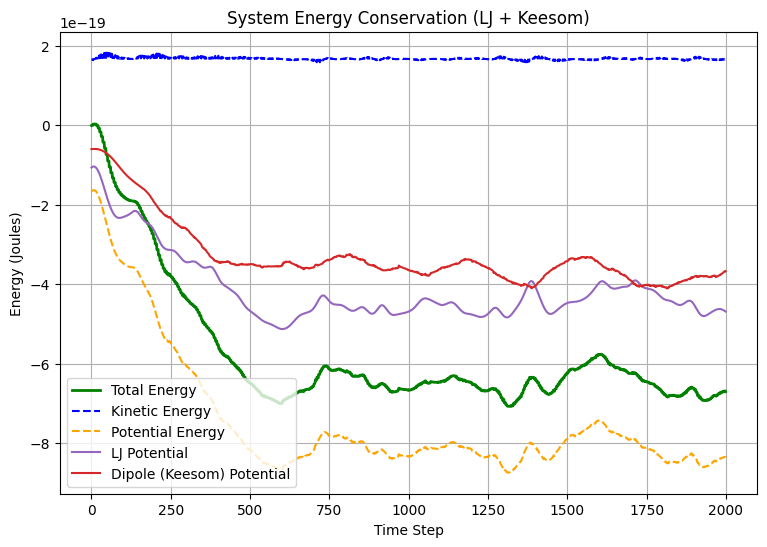

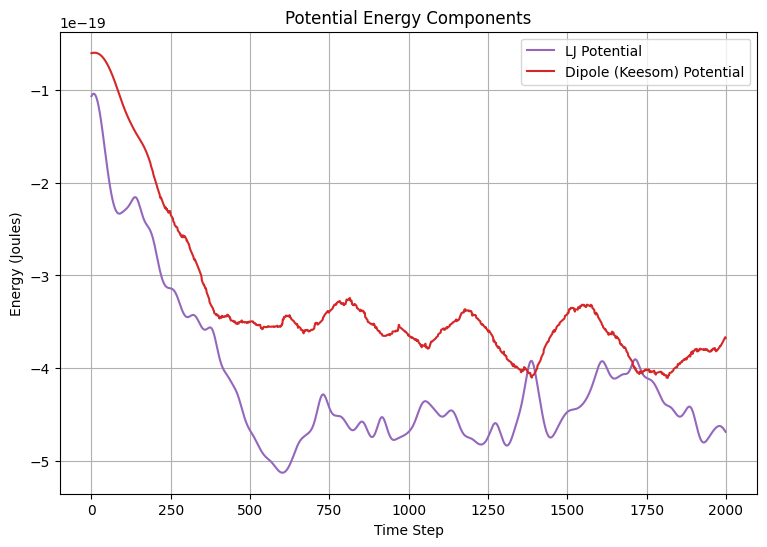

In [135]:
# =============================================
# Plot 1: Main Energy Conservation Plot
# =============================================
plt.figure(figsize=(9, 6))
plt.plot(TE, label='Total Energy', color='green', linewidth=2)
plt.plot(KE, label='Kinetic Energy', color='blue', linestyle='--')
plt.plot(PE, label='Potential Energy', color='orange', linestyle='--')
plt.plot(LJpotlist, label='LJ Potential', color='tab:purple')
plt.plot(dippotlist, label='Dipole (Keesom) Potential', color='tab:red')
plt.xlabel('Time Step')
plt.ylabel('Energy (Joules)')  # Corrected unit
plt.title('System Energy Conservation (LJ + Keesom)') # Corrected title
plt.legend()
plt.grid(True)
plt.show()

# =============================================
# Plot 2: Potential Energy Components
# =============================================
plt.figure(figsize=(9, 6))
plt.plot(LJpotlist, label='LJ Potential', color='tab:purple')
plt.plot(dippotlist, label='Dipole (Keesom) Potential', color='tab:red')
plt.xlabel('Time Step')
plt.ylabel('Energy (Joules)') # Corrected unit
plt.title('Potential Energy Components') # Corrected title
plt.legend()
plt.grid(True)
plt.show()

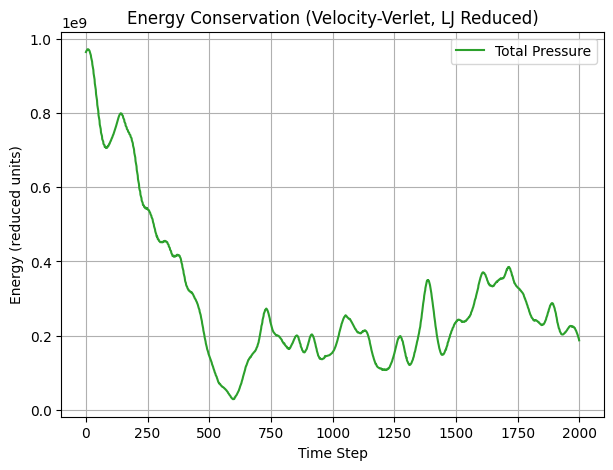

In [136]:
# Pressure using the virial expansion:
P_avg = np.mean(P_history)

plt.figure(figsize=(7, 5))
plt.plot(P_history, label='Total Pressure', color='tab:green')
plt.xlabel('Time Step')
plt.ylabel('Energy (reduced units)')
plt.title('Energy Conservation (Velocity-Verlet, LJ Reduced)')
plt.legend()
plt.grid(True)
plt.show()

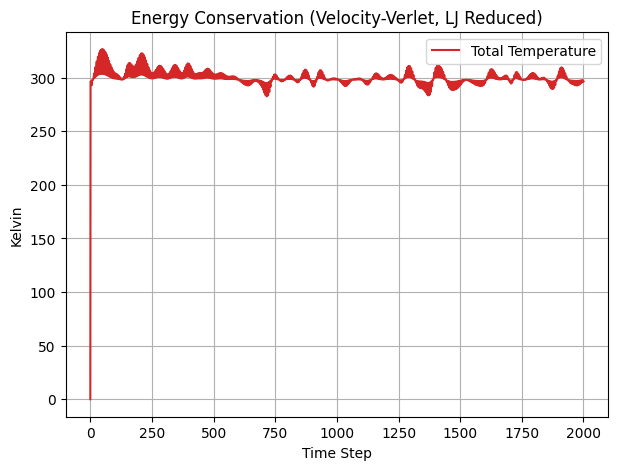

In [137]:
# Temperature analysis
plt.figure(figsize=(7, 5))
plt.plot(Tinst_history, label='Total Temperature', color='tab:red')
plt.xlabel('Time Step')
plt.ylabel('Kelvin')
plt.title('Energy Conservation (Velocity-Verlet, LJ Reduced)')
plt.legend()
plt.grid(True)
plt.show()

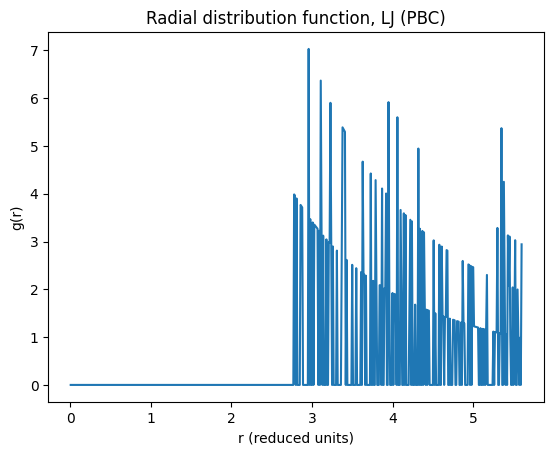

In [138]:
# Call the radial distribution function

r, g = radial_distribution(traj, L, dr_A=0.01)
plt.plot(r, g)
plt.xlabel('r (reduced units)')
plt.ylabel('g(r)')
plt.title('Radial distribution function, LJ (PBC)')
plt.show()

In [139]:
# Write xyz to the file

write_extended_xyz("traj_ext.xyz", traj, L, particle_type)

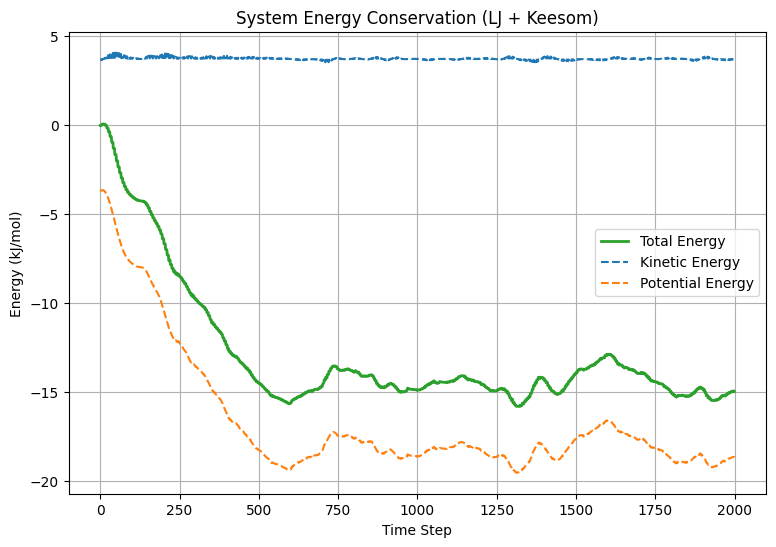

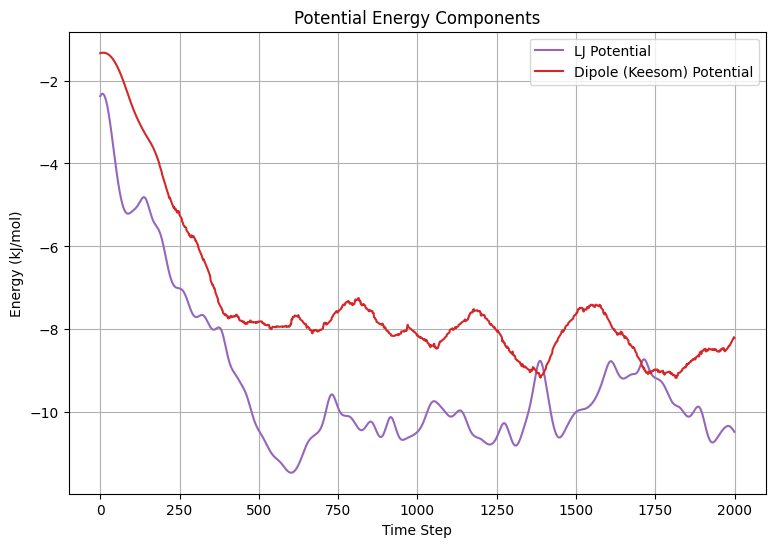

In [140]:
# =============================================
# Plot 1: Main Energy Conservation Plot
# =============================================
# --- Convert J/system to kJ/mol ---
# 1. Convert lists to numpy arrays
AVOGADRO = 6.03*10**23

PE_array_J = np.array(PE)
KE_array_J = np.array(KE)
TE_array_J = np.array(TE)

# 2. Convert from total energy to energy per particle
PE_per_particle = PE_array_J / N_total
KE_per_particle = KE_array_J / N_total
TE_per_particle = TE_array_J / N_total

# 3. Define the conversion factor from J/particle to kJ/mol
J_per_particle_to_kJ_per_mol = (AVOGADRO / 1000.0)

# 4. Apply the conversion
PE_molar = PE_per_particle * J_per_particle_to_kJ_per_mol
KE_molar = KE_per_particle * J_per_particle_to_kJ_per_mol
TE_molar = TE_per_particle * J_per_particle_to_kJ_per_mol
# ---

plt.figure(figsize=(9, 6))
plt.plot(TE_molar, label='Total Energy', color='tab:green', linewidth=2)
plt.plot(KE_molar, label='Kinetic Energy', color='tab:blue', linestyle='--')
plt.plot(PE_molar, label='Potential Energy', color='tab:orange', linestyle='--')

plt.xlabel('Time Step')
plt.ylabel('Energy (kJ/mol)')  # <-- Corrected unit
plt.title('System Energy Conservation (LJ + Keesom)')
plt.legend()
plt.grid(True)
plt.show()

# =============================================
# Plot 2: Potential Energy Components
# =============================================
# --- Apply the same conversion ---
LJ_molar = (np.array(LJpotlist) / N_total) * J_per_particle_to_kJ_per_mol
Dipole_molar = (np.array(dippotlist) / N_total) * J_per_particle_to_kJ_per_mol
# ---

plt.figure(figsize=(9, 6))
plt.plot(LJ_molar, label='LJ Potential', color='tab:purple')
plt.plot(Dipole_molar, label='Dipole (Keesom) Potential', color='tab:red')
plt.xlabel('Time Step')
plt.ylabel('Energy (kJ/mol)') # <-- Corrected unit
plt.title('Potential Energy Components')
plt.legend()
plt.grid(True)
plt.show()